In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-v0_8')  # Updated style specification
sns.set_theme(style="whitegrid")  # Using seaborn's theme
sns.set_palette("viridis")

# 1. Data Loading and **Preprocessing**

In [4]:
df = pd.read_csv('Startup_Scoring_Dataset.csv')
# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB
None

First 5 rows:
  startup_id  team_experience  market_size_million_usd  monthly_active_users  \
0       S001                7                      789                 66299   
1       S002                4                      939                 34866   
2       S003                8                       42                 73630   
3       S004    

# 2. Data Preprocessing - Normalization

In [5]:
# Create a copy for normalization
df_normalized = df.copy()

# Initialize scaler
scaler = MinMaxScaler()

# Columns to normalize (all except startup_id)
columns_to_normalize = ['team_experience', 'market_size_million_usd', 'monthly_active_users',
                       'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr']

# Define directions for normalization (1 for higher is better, -1 for higher is worse)
normalization_directions = {
    'team_experience': 1,
    'market_size_million_usd': 1,
    'monthly_active_users': 1,
    'monthly_burn_rate_inr': -1,  # Higher burn rate is worse
    'funds_raised_inr': 1,
    'valuation_inr': 1
}

# Apply Min-Max normalization with direction consideration
for col in columns_to_normalize:
    if normalization_directions.get(col, 1) == 1:
        df_normalized[col] = scaler.fit_transform(df[[col]])
    else:
        # For negative direction, we inverse the normalized values
        df_normalized[col] = 1 - scaler.fit_transform(df[[col]])

# Verify normalization
print("\nNormalized data summary:")
print(df_normalized.describe())


Normalized data summary:
       team_experience  market_size_million_usd  monthly_active_users  \
count       100.000000               100.000000            100.000000   
mean          0.545556                 0.544297              0.522761   
std           0.319033                 0.274975              0.298954   
min           0.000000                 0.000000              0.000000   
25%           0.222222                 0.338849              0.263950   
50%           0.555556                 0.574338              0.527572   
75%           0.777778                 0.754582              0.755036   
max           1.000000                 1.000000              1.000000   

       monthly_burn_rate_inr  funds_raised_inr  valuation_inr  
count             100.000000        100.000000     100.000000  
mean                0.477159          0.453185       0.454122  
std                 0.286907          0.329663       0.284698  
min                 0.000000          0.000000       0.00000

# 3. Define Custom Scoring Formula

In [6]:
# Define weights for each factor (sum to 1)
weights = {
    'team_experience': 0.15,
    'market_size_million_usd': 0.20,
    'monthly_active_users': 0.25,
    'monthly_burn_rate_inr': 0.10,
    'funds_raised_inr': 0.15,
    'valuation_inr': 0.15
}

# Calculate composite score (out of 100)
df_normalized['composite_score'] = (
    df_normalized['team_experience'] * weights['team_experience'] +
    df_normalized['market_size_million_usd'] * weights['market_size_million_usd'] +
    df_normalized['monthly_active_users'] * weights['monthly_active_users'] +
    df_normalized['monthly_burn_rate_inr'] * weights['monthly_burn_rate_inr'] +
    df_normalized['funds_raised_inr'] * weights['funds_raised_inr'] +
    df_normalized['valuation_inr'] * weights['valuation_inr']
) * 100

# Round scores to 2 decimal places
df_normalized['composite_score'] = df_normalized['composite_score'].round(2)

# Merge with original data for comparison
df_final = pd.merge(df, df_normalized[['startup_id', 'composite_score']], on='startup_id')

# 4. Ranking & Interpretation

In [7]:
# Sort by composite score
df_ranked = df_final.sort_values('composite_score', ascending=False)
# Get top 10 and bottom 10
top_10 = df_ranked.head(10)
bottom_10 = df_ranked.tail(10).sort_values('composite_score')
print("\nTop 10 Startups:")
print(top_10[['startup_id', 'composite_score']].to_string(index=False))
print("\nBottom 10 Startups:")
print(bottom_10[['startup_id', 'composite_score']].to_string(index=False))


Top 10 Startups:
startup_id  composite_score
      S006            81.04
      S077            77.05
      S045            75.66
      S033            74.94
      S013            74.68
      S029            73.11
      S097            70.04
      S012            69.81
      S008            69.67
      S043            69.55

Bottom 10 Startups:
startup_id  composite_score
      S055            19.09
      S098            26.16
      S023            26.26
      S058            28.57
      S084            30.14
      S079            30.43
      S051            32.32
      S061            32.96
      S017            33.53
      S074            33.66


# 5. Visualization

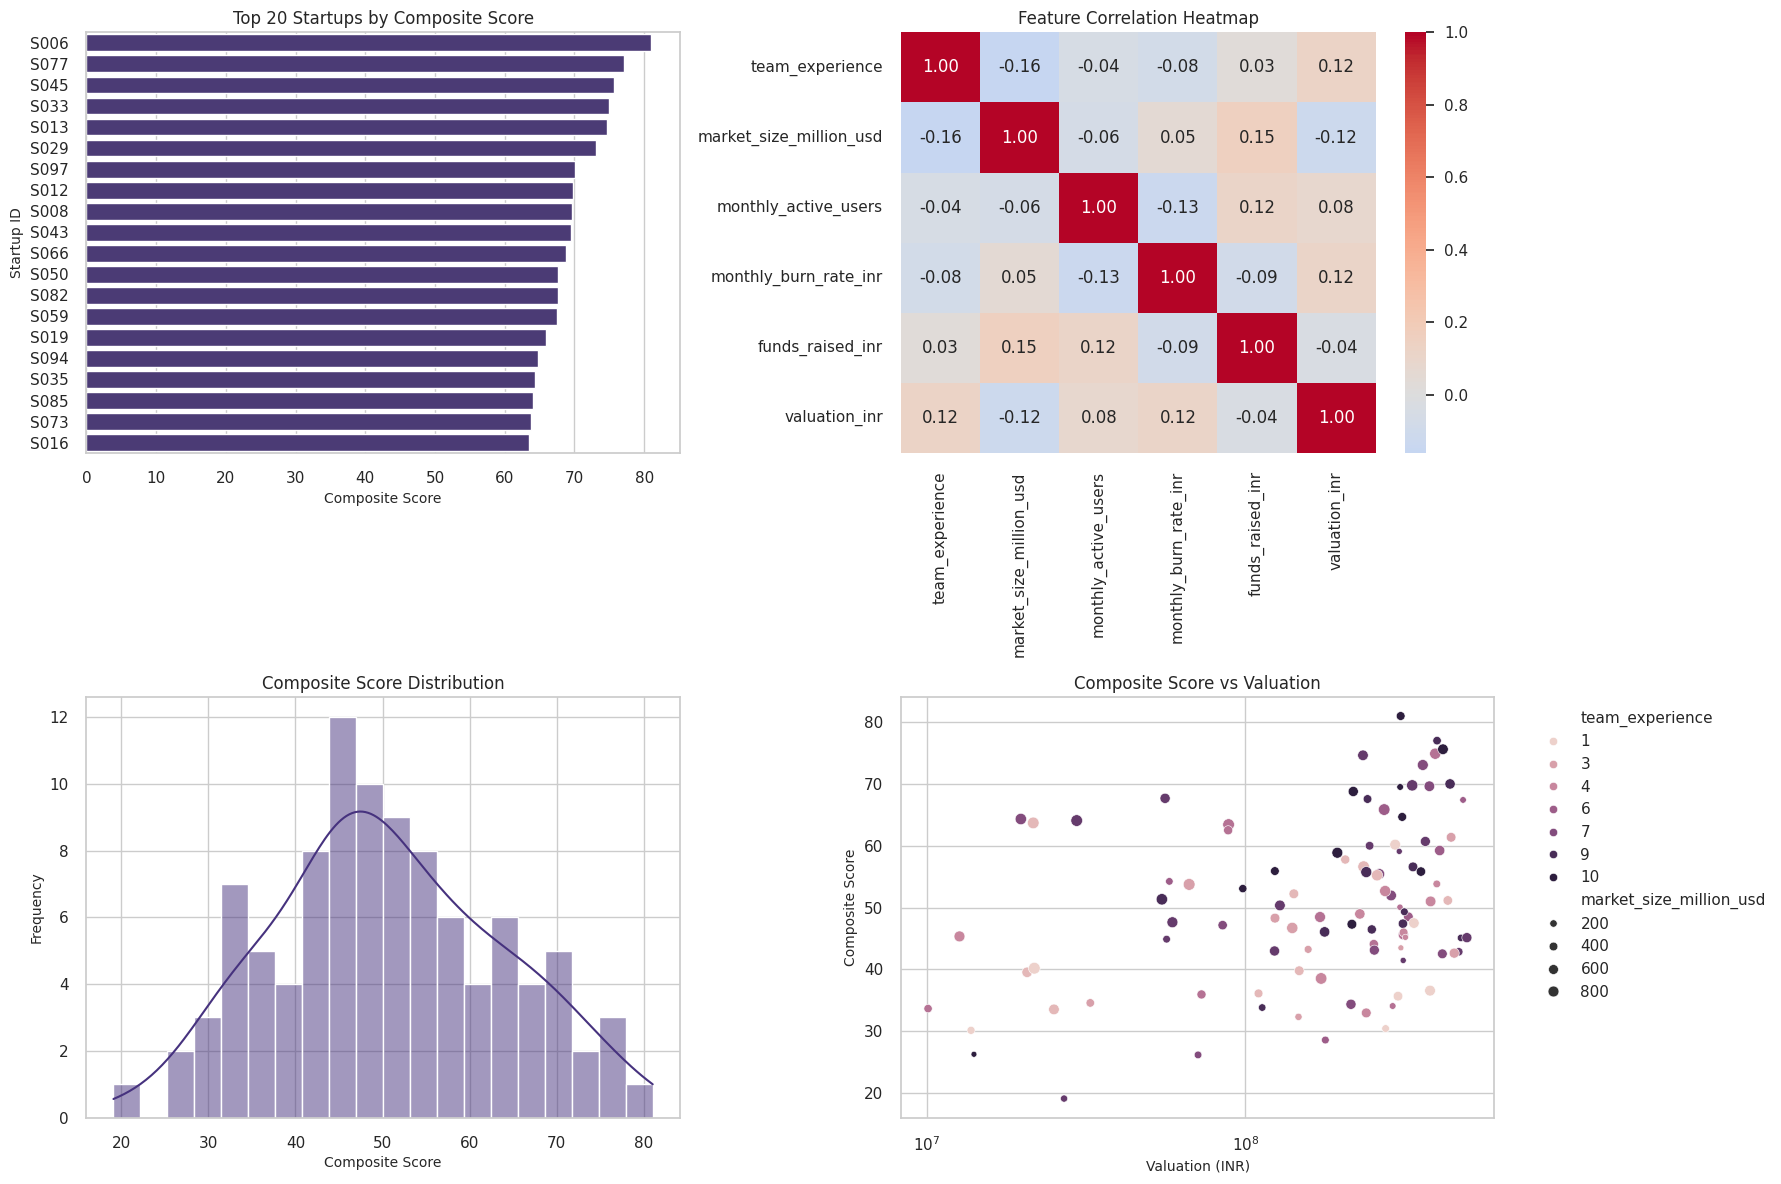

In [8]:
# Set up figure and axes
plt.figure(figsize=(18, 12))

# Bar chart of scores (sorted)
plt.subplot(2, 2, 1)
sns.barplot(x='composite_score', y='startup_id', data=df_ranked.head(20),
            order=df_ranked.head(20)['startup_id'])
plt.title('Top 20 Startups by Composite Score', fontsize=12)
plt.xlabel('Composite Score', fontsize=10)
plt.ylabel('Startup ID', fontsize=10)

# Correlation heatmap
plt.subplot(2, 2, 2)
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=12)

# Score distribution histogram
plt.subplot(2, 2, 3)
sns.histplot(df_final['composite_score'], bins=20, kde=True)
plt.title('Composite Score Distribution', fontsize=12)
plt.xlabel('Composite Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Scatter plot of score vs valuation
plt.subplot(2, 2, 4)
sns.scatterplot(x='valuation_inr', y='composite_score', data=df_final, hue='team_experience', size='market_size_million_usd')
plt.title('Composite Score vs Valuation', fontsize=12)
plt.xlabel('Valuation (INR)', fontsize=10)
plt.ylabel('Composite Score', fontsize=10)
plt.xscale('log')  # Using log scale for better visualization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 6. Explanation of High and Low Performers

In [9]:
# Example explanation for top and bottom performers
top_performer = df_ranked.iloc[0]
bottom_performer = df_ranked.iloc[-1]

print("\nExplanation of High and Low Performers:")
print(f"\nTop Performer (Startup ID: {top_performer['startup_id']}, Score: {top_performer['composite_score']}):")
print(f"- Team experience: {top_performer['team_experience']}/10")
print(f"- Market size: ${top_performer['market_size_million_usd']} million")
print(f"- Monthly active users: {top_performer['monthly_active_users']:,}")
print(f"- Monthly burn rate: INR {top_performer['monthly_burn_rate_inr']:,}")
print(f"- Funds raised: INR {top_performer['funds_raised_inr']:,}")
print(f"- Valuation: INR {top_performer['valuation_inr']:,}")

print(f"\nBottom Performer (Startup ID: {bottom_performer['startup_id']}, Score: {bottom_performer['composite_score']}):")
print(f"- Team experience: {bottom_performer['team_experience']}/10")
print(f"- Market size: ${bottom_performer['market_size_million_usd']} million")
print(f"- Monthly active users: {bottom_performer['monthly_active_users']:,}")
print(f"- Monthly burn rate: INR {bottom_performer['monthly_burn_rate_inr']:,}")
print(f"- Funds raised: INR {bottom_performer['funds_raised_inr']:,}")
print(f"- Valuation: INR {bottom_performer['valuation_inr']:,}")

# Additional analysis - Score distribution statistics
print("\nScore Distribution Statistics:")
print(f"Mean score: {df_final['composite_score'].mean():.2f}")
print(f"Median score: {df_final['composite_score'].median():.2f}")
print(f"Highest score: {df_final['composite_score'].max():.2f}")
print(f"Lowest score: {df_final['composite_score'].min():.2f}")
print(f"Standard deviation: {df_final['composite_score'].std():.2f}")

# Save results to CSV
df_ranked.to_csv('startup_scores_ranked.csv', index=False)
print("\nResults saved to 'startup_scores_ranked.csv'")


Explanation of High and Low Performers:

Top Performer (Startup ID: S006, Score: 81.04):
- Team experience: 10/10
- Market size: $416 million
- Monthly active users: 95,939
- Monthly burn rate: INR 551,157
- Funds raised: INR 48,939,582
- Valuation: INR 307,433,345

Bottom Performer (Startup ID: S055, Score: 19.09):
- Team experience: 8/10
- Market size: $169 million
- Monthly active users: 2,911
- Monthly burn rate: INR 7,029,451
- Funds raised: INR 1,043,233
- Valuation: INR 26,934,380

Score Distribution Statistics:
Mean score: 50.52
Median score: 48.76
Highest score: 81.04
Lowest score: 19.09
Standard deviation: 13.03

Results saved to 'startup_scores_ranked.csv'
